In [1]:
import scipy.io as spio
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
font = {'size': 14}
matplotlib.rc('font', **font)

# Annotate 10 random samples from each dataset

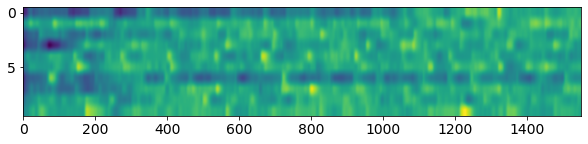

 1
 0
 1
 1
 0
 0
 0
 1
 0
 0


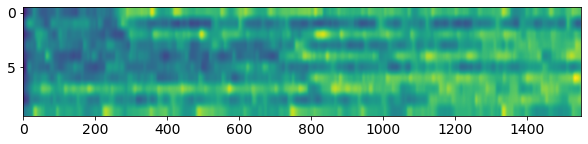

 1
 0
 1
 1
 1
 0
 1
 0
 1
 0


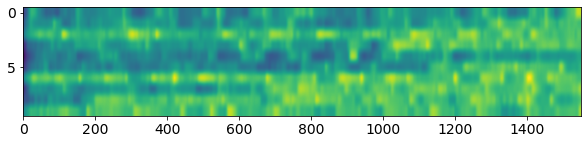

 0
 1
 0
 1
 0
 1
 0
 1
 1
 0


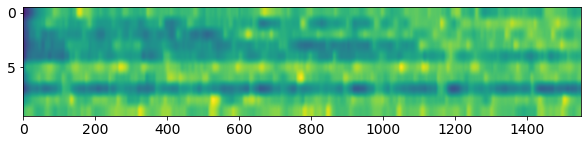

 0
 0
 1
 1
 0
 0
 0
 0
 0
 0


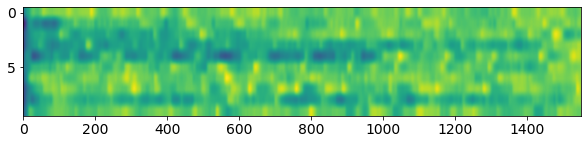

 0
 1
 1
 1
 1
 0
 0
 1
 0
 0


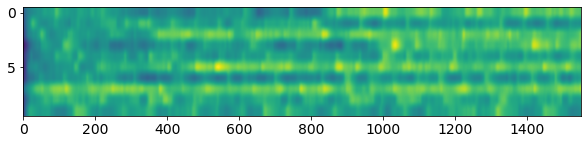

 1
 0
 1
 1
 0
 1
 0
 0
 0
 0


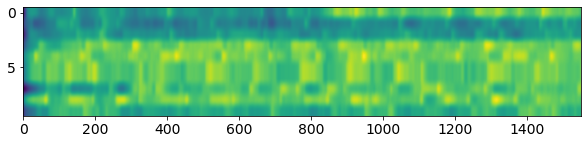

 1
 0
 0
 1
 0
 0
 0
 1
 0
 0


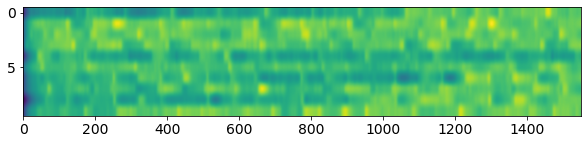

 1
 0
 0
 0
 0
 0
 1
 1
 1
 1


In [296]:
d1 = '2022_04_25_2307_shuttle_initT_0.25T_amp_60mV_distance_420nm_reloffset_185mV_f_shuttle_5Hz_3in_repRead_per_period_7flush_fill_n_empty'
d2 = '2022_04_26_0024_shuttle_initT_0.25T_amp_60mV_distance_560nm_reloffset_185mV_f_shuttle_5Hz_4in_repRead_per_period_9flush_fill_n_empty'
d3 = '2022_04_26_0158_shuttle_initT_0.25T_amp_60mV_distance_700nm_reloffset_185mV_f_shuttle_5Hz_5in_repRead_per_period_11flush_fill_n_empty'
d4 = '2022_04_26_0349_shuttle_initT_0.25T_amp_60mV_distance_840nm_reloffset_185mV_f_shuttle_5Hz_6in_repRead_per_period_13flush_fill_n_empty'
d5 = '2022_04_26_0558_shuttle_initT_0.25T_amp_60mV_distance_980nm_reloffset_185mV_f_shuttle_5Hz_7in_repRead_per_period_15flush_fill_n_empty'
d6 = '2022_04_26_1007_shuttle_initT_0.25T_amp_60mV_distance_1120nm_reloffset_185mV_f_shuttle_5Hz_8in_repRead_per_period_17flush_fill_n_empty'
d7 = '2022_04_26_1115_shuttle_initT_0.25T_amp_60mV_distance_1260nm_reloffset_185mV_f_shuttle_5Hz_9in_repRead_per_period_19flush_fill_n_empty'
d8 = '2022_04_26_1231_shuttle_initT_0.25T_amp_60mV_distance_1400nm_reloffset_185mV_f_shuttle_5Hz_10in_repRead_per_period_21flush_fill_n_empty'

start = 33_200 # start of reading window for first dataset (420nm)
offset = 8_330 # offset of start of reading window between datasets
width = 1_550 # (sample) width of reading window

X = []
Y = []

for i,d in enumerate([d1,d2,d3,d4,d5,d6,d7,d8]):
    database = spio.loadmat('./shuttle_dataset/%s.mat' % d)
    data = database['data'][0][2]
    reads = data[:, int(start+i*offset) : int(start+width+i*offset)]
    
    x = reads[np.random.randint(0,100,10), :]
    X.append(x)
    plt.figure(figsize=(10,2))
    plt.imshow(x)
    plt.axis('tight')
    plt.show()
    
    for j in range(10):
        y = int(input())
        Y.append(y)
        
X = np.array(X).reshape(-1,width)
Y = np.array(Y)

np.save('x_train.npy', X)
np.save('y_train.npy', Y)

Here, left the selected samples and right our annotations (1: blip, 0: no blip)

(-0.5, 0.5, 79.5, -0.5)

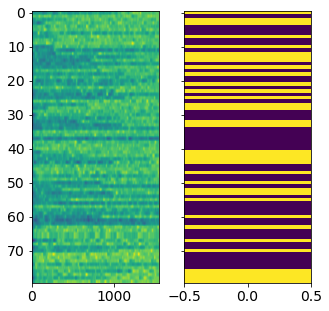

In [297]:
x = np.load('x_train.npy')
y = np.load('y_train.npy')

fig, ax = plt.subplots(1,2, figsize=(5,5), sharey=True)
ax[0].imshow(x)
ax[0].axis('tight')

ax[1].imshow(y[:,None])
ax[1].axis('tight')

# Train the model

In [299]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(500, input_dim=1550, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')

model.fit(x,y,epochs=90,batch_size=10)

Epoch 1/90
8/8 [==============================] - 0s 5ms/step - loss: 0.7049
Epoch 2/90
8/8 [==============================] - 0s 5ms/step - loss: 0.7250
Epoch 3/90
8/8 [==============================] - 0s 4ms/step - loss: 0.6842
Epoch 4/90
8/8 [==============================] - 0s 6ms/step - loss: 0.6841
Epoch 5/90
8/8 [==============================] - 0s 6ms/step - loss: 0.6807
Epoch 6/90
8/8 [==============================] - 0s 5ms/step - loss: 0.6800
Epoch 7/90
8/8 [==============================] - 0s 5ms/step - loss: 0.6809
Epoch 8/90
8/8 [==============================] - 0s 4ms/step - loss: 0.6812
Epoch 9/90
8/8 [==============================] - 0s 5ms/step - loss: 0.6767
Epoch 10/90
8/8 [==============================] - 0s 5ms/step - loss: 0.6780
Epoch 11/90
8/8 [==============================] - 0s 5ms/step - loss: 0.6791
Epoch 12/90
8/8 [==============================] - 0s 4ms/step - loss: 0.6802
Epoch 13/90
8/8 [==============================] - 0s 4ms/step - loss: 0.

# Evaluate model

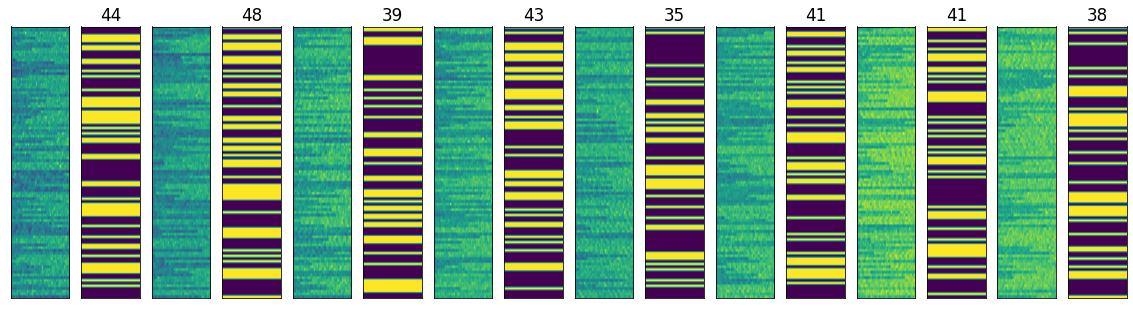

In [300]:
rates = []
fig, ax = plt.subplots(1, 8*2, figsize=(20,5), sharey=True)

for i,d in enumerate([d1,d2,d3,d4,d5,d6,d7,d8]):
    database = spio.loadmat('./shuttle_dataset/%s.mat' % d)
    data = database['data'][0][2]
    reads = data[:, int(start+i*dist) : int(start+width+i*offset)]
    y_pred = model.predict(reads, verbose=False)
    y_bin = np.where(y_pred > 0.5, 1, 0)
    success_counts = np.count_nonzero(y_bin)
    rates.append(success_counts / 100)

    ax[i*2].imshow(reads)
    ax[i*2].axis('tight')
    
    ax[i*2+1].set_title(success_counts)
    ax[i*2+1].imshow(y_bin)
    ax[i*2+1].axis('tight')
    
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    
plt.show()

(0.0, 1.0)

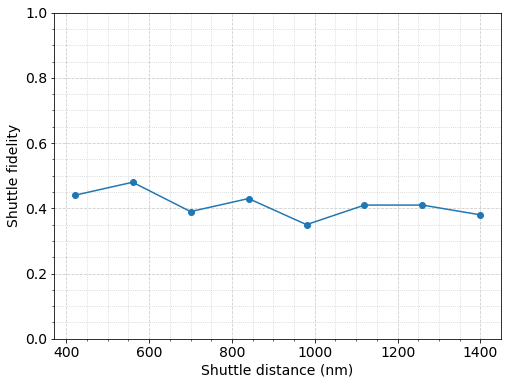

In [301]:

lens = [420, 560, 700, 840, 980, 1120, 1260, 1400]

plt.figure(figsize=(8,6))
plt.plot(lens, rates, 'o-')

plt.xlabel('Shuttle distance (nm)');
plt.ylabel('Shuttle fidelity');
plt.minorticks_on()
plt.grid(which='major', color='#CCCCCC', linestyle='--')
plt.grid(which='minor', color='#CCCCCC', linestyle=':')
plt.ylim(0,1)